In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
from matplotlib.tri import Triangulation
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import re
import pickle
import fastai
import os



# Functions 

In [2]:
class IVSDataset(Dataset):

    def __init__(self, path, transform=None):
        # Load the data
        # TODO --> the arg 'usecols' in self.data is hardcoded, this should ALWAYS refer to implied vol
        self.data = np.loadtxt(path, delimiter=",", dtype=np.float32,
                               skiprows=1, usecols=(6,))
        self.dates = pd.read_csv(path, usecols=['date'])
        self.transform = transform

    def __len__(self):
        # Each date has 40 observations
        return len(self.data) // 40

    def __getitem__(self, idx):
        # Extract the rows corresponding to the idx-th date
        start_idx = idx * 40
        end_idx = start_idx + 40

        # Makes sure to obtain correct data if indexing happens from the back with negative vals
        if end_idx == 0:
            sample = self.data[start_idx:]
        else:
            sample = self.data[start_idx:end_idx]

        # Extract features and target from the sample
        features = sample[:]
        target = sample

        # Convert to tensor
        features = torch.tensor(features, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        # Obtain the corresponding string date
        date = self.dates.iloc[start_idx][0]

        if self.transform:
            features = self.transform(features)

        return features, target

class Autoencoder(nn.Module):
    def __init__(self, architecture, latent_size):
        self.architecture = architecture
        self.latent_size = latent_size
        # N, 40
        super().__init__()
        self.encoder_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()

        # The length of the architecture
        enc_dec_len = int((len(architecture) - 1) / 2)

        # Separate the architecture of decoder and encoder
        encoder_arch = architecture[:enc_dec_len]
        decoder_arch = architecture[enc_dec_len + 1:]

        # Encoder
        for i in range(enc_dec_len):
            if i == 0:
                self.encoder_layers.append(nn.Linear(input_size, encoder_arch[i]))
                self.encoder_layers.append(nn.ReLU())
                self.encoder_layers.append(nn.BatchNorm1d(encoder_arch[i]))
            else:
                self.encoder_layers.append(nn.Linear(encoder_arch[i - 1], encoder_arch[i]))
                self.encoder_layers.append(nn.ReLU())
                self.encoder_layers.append(nn.BatchNorm1d(encoder_arch[i]))

        # Create the latent layer
        self.encoder_layers.append(nn.Linear(encoder_arch[-1], latent_size))
        self.encoder_layers.append(nn.ReLU())
        self.encoder_layers.append(nn.BatchNorm1d(latent_size))

        # Decoder
        for i in range(enc_dec_len):
            if i == 0:
                self.decoder_layers.append(nn.Linear(latent_size, decoder_arch[i]))
                self.decoder_layers.append(nn.ReLU())
                self.decoder_layers.append(nn.BatchNorm1d(decoder_arch[i]))
            else:
                self.decoder_layers.append(nn.Linear(decoder_arch[i - 1], decoder_arch[i]))
                self.decoder_layers.append(nn.ReLU())
                self.decoder_layers.append(nn.BatchNorm1d(decoder_arch[i]))


        # Build output layer
        self.decoder_layers.append(nn.Linear(decoder_arch[-1], 40))
        self.decoder_layers.append(nn.Sigmoid())

        # Convert to Sequential modules
        self.encoder = nn.Sequential(*self.encoder_layers)
        self.decoder = nn.Sequential(*self.decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        # encoded = model.add_contract_to_z(encoded,)
        print(f'latent vec of current sample: {encoded}')
        decoded = self.decoder(encoded)
        return decoded

    def get_z(self, x):
        z = self.encoder(x)
        return z
    


In [3]:
# Function to convert string representation of numpy array to actual numpy array
def string_to_array(s):
    # Remove brackets and split the string into a list of values
    values = s.strip('[]').split()
    # Convert each value to an integer
    array = np.array([float(val) for val in values])
    return array

In [4]:
def plot_IVS(reconstructed_surf):

    grid_points = [[30, 60, 91, 182, 273, 365, 547, 730], [10, 25, 50, 75, 90]]
    tensor_list = reconstructed_surf.tolist()  # Convert to a flat list

    # Ensure lengths match
    assert len(tensor_list) == len(grid_points[0]) * len(grid_points[1]), "Length mismatch between tensor and grid points"

    # Create a list of tuples containing grid point pairs and corresponding tensor values
    data = []
    for x in grid_points[0]:
        for y in grid_points[1]:
            data.append((x, y, tensor_list.pop(0)))

    # Create a DataFrame
    columns = ['T', 'delta', 'vol']
    df = pd.DataFrame(data, columns=columns)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D plane
    ax.scatter(df['delta'], df['T'], df['vol'], c='b', marker='o')

    # Set labels for the axes
    ax.set_xlabel('Delta')
    ax.set_ylabel('T')
    ax.set_zlabel('Vol')

    # Display the 3D plot
    plt.show()

    #create 2d plot
    # Reshape the DataFrame for heatmap
    heatmap_data = df.pivot('delta', 'T', 'vol')

    # Create a custom colormap
    colors = [(0, 'navy'), (0.25, 'cornflowerblue'), (0.75, 'lightcoral'), (1, 'darkred')]
    cmap = LinearSegmentedColormap.from_list("CustomColormap", colors)

    # Create a 2D heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".4f", linewidths=.5)

    # Set labels for the axes
    plt.ylabel('Delta')
    plt.xlabel('T')


    # Display the 2D heatmap
    plt.show()


    # Create a 3D plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Create a meshgrid for delta and T
    delta, T = np.meshgrid(heatmap_data.columns, heatmap_data.index)

    # Plot the 3D surface with plot_surface
    surf = ax.plot_surface(T, delta, heatmap_data.values, cmap=cmap, rstride=1, cstride=1, linewidth=0, antialiased=True)

    # Set labels for the axes
    ax.set_ylabel('T')
    ax.set_xlabel('Delta')
    ax.set_zlabel('Volatility')

    # Add a colorbar for reference
    cbar = fig.colorbar(surf, ax=ax, pad=0.01)
    cbar.set_label('Volatility')

    # Display the 3D plot
    plt.show()

In [5]:
def plot_2d_heatmap(surface):
    grid_points = [[30, 60, 91, 182, 273, 365, 547, 730], [10, 25, 50, 75, 90]]
    tensor_list = surface.tolist()  # Convert to a flat list

    # Ensure lengths match
    assert len(tensor_list) == len(grid_points[0]) * len(grid_points[1]), "Length mismatch between tensor and grid points"

    # Create a list of tuples containing grid point pairs and corresponding tensor values
    data = []
    for x in grid_points[0]:
        for y in grid_points[1]:
            data.append((x, y, tensor_list.pop(0)))

    # Create a DataFrame
    columns = ['T', 'delta', 'vol']
    df = pd.DataFrame(data, columns=columns)

    #create 2d plot
    # Reshape the DataFrame for heatmap
    heatmap_data = df.pivot('delta', 'T', 'vol')

    # Create a custom colormap
    colors = [(0, 'navy'), (0.25, 'cornflowerblue'), (0.75, 'lightcoral'), (1, 'darkred')]
    cmap = LinearSegmentedColormap.from_list("CustomColormap", colors)

    # Create a 2D heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".4f", linewidths=.5)

    # Set labels for the axes
    plt.ylabel('Delta')
    plt.xlabel('T')


    # Display the 2D heatmap
    plt.show()


In [6]:
def plot_IVS_simple(reconstructed_surf, ax, title, error_surf = None):
    grid_points = [[30, 60, 91, 182, 273, 365, 547, 730], [10, 25, 50, 75, 90]]
    tensor_list = reconstructed_surf.tolist()

    assert len(tensor_list) == len(grid_points[0]) * len(grid_points[1]), "Length mismatch between tensor and grid points"

    data = []
    for x in grid_points[0]:
        for y in grid_points[1]:
            data.append((x, y, tensor_list.pop(0)))
    
    columns = ['T', 'delta', 'vol']
    df = pd.DataFrame(data, columns=columns)
    
    # Create a custom colormap
    colors = [(0, 'navy'), (0.25, 'cornflowerblue'), (0.75, 'lightcoral'), (1, 'darkred')]
    
    # If extra colours is given as input change it
    if error_surf == True:
        cmap = 'viridis'
    
    else:
        cmap = LinearSegmentedColormap.from_list("CustomColormap", colors)
    
    # Creating the 3D surface plot
    heatmap_data = df.pivot('delta', 'T', 'vol')
    # Create a meshgrid for delta and T
    delta, T = np.meshgrid(heatmap_data.columns, heatmap_data.index)

    # Plot the 3D surface with plot_surface
    surf = ax.plot_surface(T, delta, heatmap_data.values, cmap=cmap, rstride=1, cstride=1, linewidth=0, antialiased=True, alpha = 0.8)
    
    ax.set_ylabel('T (Days)')
    ax.set_xlabel('Delta')
#     if error_surf == True:
#         ax.set_zlabel('Squared Error')
#     else: 
#         ax.set_zlabel('Volatility')
    ax.set_title(title)  # Add title to subplot
    cbar = ax.figure.colorbar(surf, ax=ax, pad=0.1, shrink=0.5)
    
    if error_surf == True:
        cbar.set_label('Squared Error')
    else:
        cbar.set_label('Volatility')

# Data pre-settings

In [7]:
# Presettings
subset_size_list = ['5', '10', '15', '20', '25', '30', '35', '40']
latent_size_list = ['1', '2', '3', '4']
ticker_list = ['MSFT', 'TSLA', 'XOM', 'SPX']


# Define which loss you want to construct
error = 'MSE'

# Define if you want models trained on ALL data or just trained on own ticker data (preferred)
use_all = False
normalize_contracts = True

# Define the grid points and create a dictionary for later reference
tenor_points = [30, 60, 91, 182, 273, 365, 547, 730]
delta_points = [10, 25, 50, 75, 90]

if normalize_contracts == True:
    
    tmin, tmax = min(tenor_points), max(tenor_points)
    for i, val in enumerate(tenor_points):
        tenor_points[i] = (val-tmin) / (tmax-tmin)

    dmin, dmax = min(delta_points), max(delta_points)
    for i, val in enumerate(delta_points):
        delta_points[i] = (val-dmin) / (dmax-dmin)

grid_points = [tenor_points, delta_points]

# Flatten the grid_points to get a list of all pairs
all_pairs = [(x, y) for x in grid_points[0] for y in grid_points[1]]

# Create a dictionary with keys from 0 to 39 and corresponding grid points
grid_dict = {i: pair for i, pair in enumerate(all_pairs)}

# Create a tensorlist with the option contract pair
tensor_list = [torch.tensor(value) for value in grid_dict.values()]
contract_tensor = torch.stack(tensor_list)

# # Obtain the test date vector for reference
# ts_path = f'data/to_use/{t}_test'
# ts_df = pd.read_csv(ts_path)
# dates = ts_df['date'].unique()

# Obtain the ground-truth tensors for the sets
truth_tensor_dict = dict()

# Save the ground truth of the test set to a dictionary for later reference
for t in ticker_list:
    ts_path = f'data/to_use/{t}_test'
    ts_path = f'data/to_use/{t}_test'
    ts_df = pd.read_csv(ts_path)
    dates = ts_df['date'].unique()
    test_dataset = IVSDataset(ts_path)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    truth_list = []
    for (img, _) in test_dataloader:
        truth_list.append(img.squeeze())
    truth_tensor_dict[f'{t}'] = truth_list
    



# Part 0 | Hyper parameter analysis
This part will infer what the best hyper parameter choices are

In [11]:
t = 'TSLA'
wise = 'gridwise'
model_version = 7
hyp_df = pd.read_csv(f'data/to_use/{t}_hyperparameter_losses_{wise}_v{model_version}')
hyp_df

,Unnamed: 0,eta1,eta2,eta3,eta4,eta5
0,"wd0.001, l1, lr0.1",0.007838,0.004693,0.004657,0.005313,0.004894
1,"wd0.001, l1, lr0.01",0.008469,0.004711,0.004371,0.004393,0.004352
2,"wd0.001, l1, lr0.001",0.012835,0.006875,0.005954,0.005376,0.004916
3,"wd0.001, l1, lr0.0001",0.022266,0.017031,0.014127,0.012089,0.010668
4,"wd0.001, l2, lr0.1",0.009587,0.004429,0.005034,0.004938,0.004726
5,"wd0.001, l2, lr0.01",0.007354,0.004678,0.004373,0.004380,0.004369
6,"wd0.001, l2, lr0.001",0.012870,0.007087,0.006275,0.005672,0.005156
7,"wd0.001, l2, lr0.0001",0.022840,0.018860,0.016023,0.013790,0.012014
8,"wd0.001, l3, lr0.1",0.006920,0.004883,0.005329,0.005082,0.004359
9,"wd0.001, l3, lr0.01",0.008300,0.004909,0.004490,0.004465,0.004447


# Part 1 | Performance of trained model on full data
In this part the models performance is checked when all 40 points of the surface are visible. First the errors of the full surface are checked, and then the errors of specific regions are checked. Later, the behaviour of the latent variables is discussed

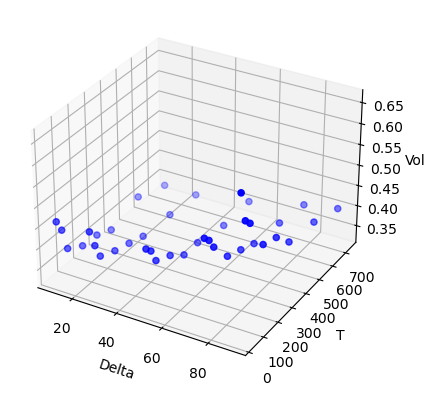

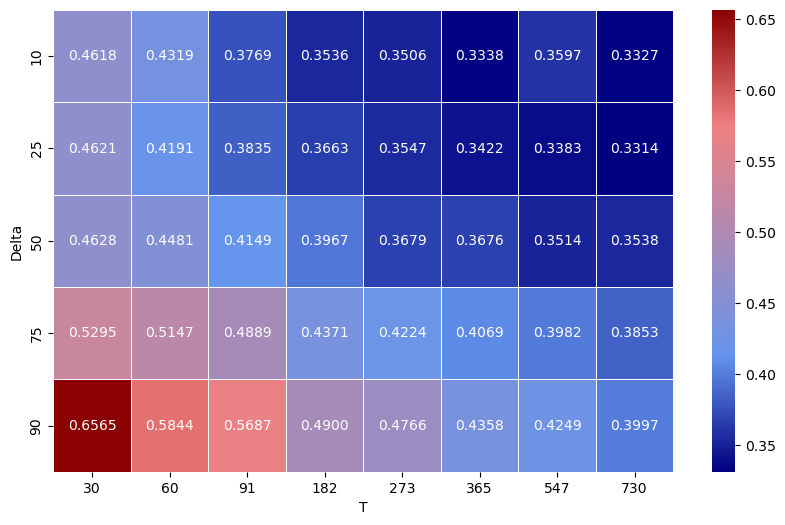

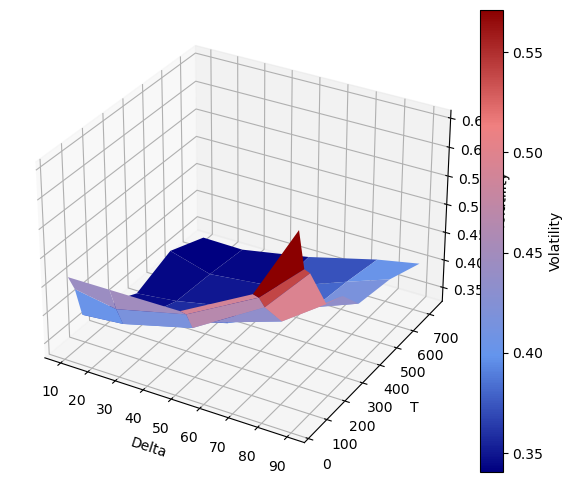

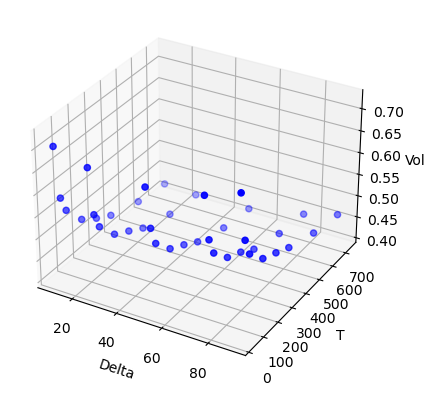

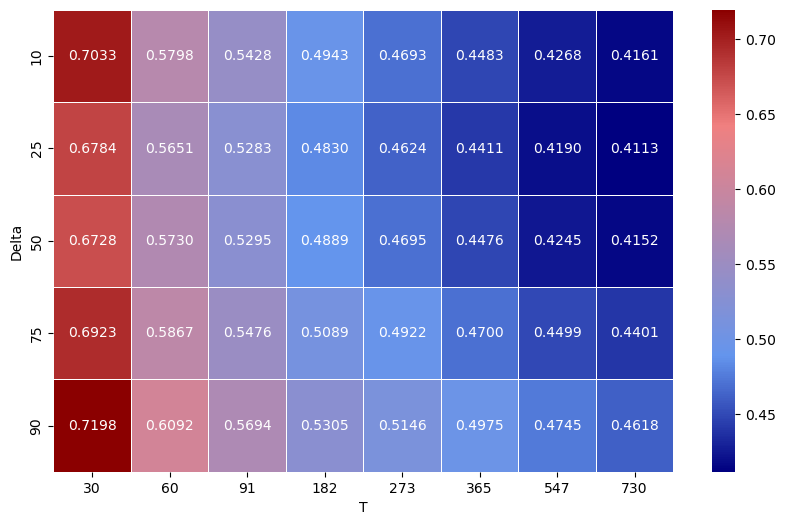

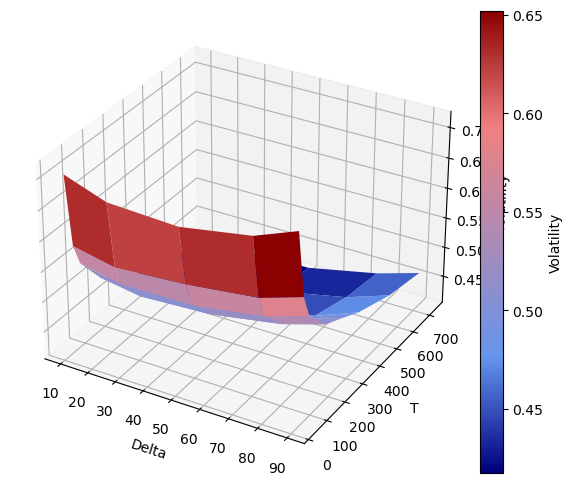

In [12]:
# Choose the model and ticker you want to analyse. Within this notebook, please keep the variable 'wise' fixed.
latent_size = 4
width = 7
model_version = 7

# Pick ticker. See cell for data_presettings for the current ticker_list
ticker = 'TSLA'
wise = 'gridwise'

# Change this number to check a different sample, 505 samples availble, first sample = 0.
# Sample number 50 corresponds to 16-03-2020, the day the COVID-19 crisis first hit the markets
sample_number = 10


# Get the path of the test set
ts_path = f'data/to_use/{ticker}_test'
test_dataset = IVSDataset(ts_path)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  

# Use dataloader
test_dataiter = iter(test_dataloader)

# Note that for this use-case the 'images' are the same as the 'labels'
ts_images, ts_labels = next(test_dataiter)

# Create a list of all the testsamples
test_sample_list = []
for (img, _) in test_dataloader:
    test_sample_list.append(img)
    

model = torch.load(f'data/to_use/models/{wise}/{ticker}/{ticker}_model_latentdim{latent_size}_width{width}_v{model_version}')
# model = torch.load(f'data/to_use/models/pointwise/ALL/ALL_model_latentdim{latent_size}_width{width}_v{model_version}')
model.eval()

with torch.no_grad():
    z = model.encoder(test_sample_list[sample_number])
    reconstructed_surf = model.decoder(z)
    plot_IVS(reconstructed_surf.squeeze())
    plot_IVS(test_sample_list[sample_number].detach().squeeze())

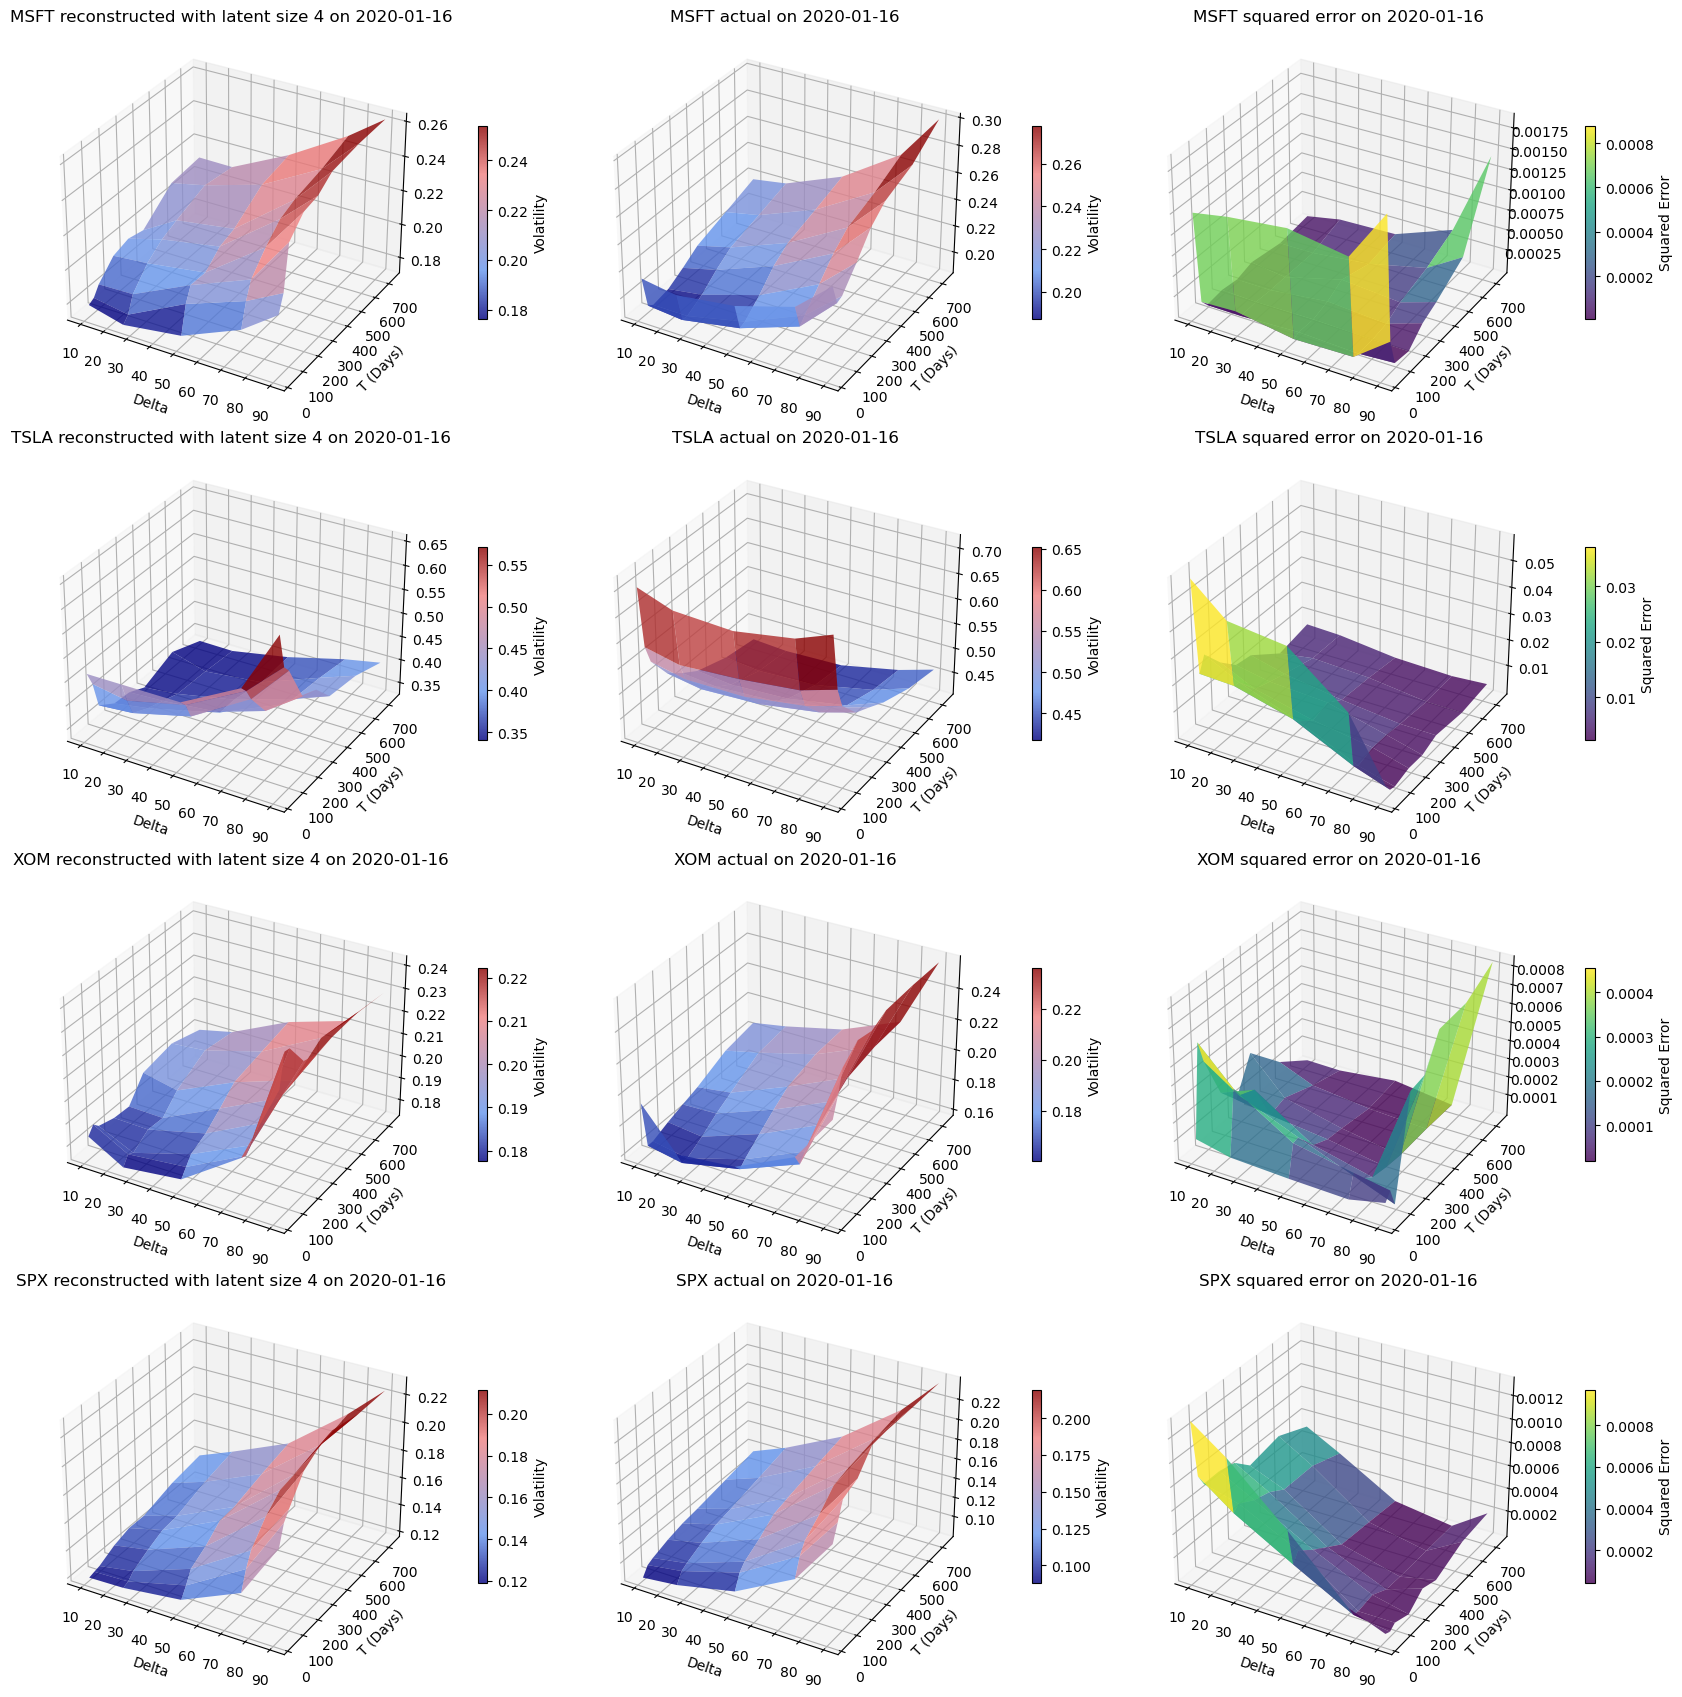

In [13]:
# Choose the model and ticker you want to analyse. Within this notebook, please keep the variable 'wise' fixed.
latent_size = 4
width = 7
model_version = 7
covid_sample = 54
normal_sample = 10
wise = 'gridwise'

sample_number = normal_sample

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(17, 17), subplot_kw={'projection': '3d'})

# Flatten the 2D array of subplots to simplify indexing
axs = axs.flatten()


# Loop over all the ticker
i = 0
for ticker in ticker_list:
    model = torch.load(f'data/to_use/models/{wise}/{ticker}/{ticker}_model_latentdim{latent_size}_width{width}_v{model_version}')
    model.eval()
    
    # Get the path of the test set
    ts_path = f'data/to_use/{ticker}_test'
    test_dataset = IVSDataset(ts_path)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  

    # Use dataloader
    test_dataiter = iter(test_dataloader)

    # Note that for this use-case the 'images' are the same as the 'labels'
    ts_images, ts_labels = next(test_dataiter)

    # Create a list of all the testsamples
    test_sample_list = []
    for (img, _) in test_dataloader:
        test_sample_list.append(img)

    with torch.no_grad():
        z = model.encoder(test_sample_list[sample_number])
        reconstructed_surf = model.decoder(z)
        plot_IVS_simple(reconstructed_surf.squeeze(), ax=axs[i], title=f'{ticker} reconstructed with latent size {latent_size} on {dates[sample_number]}')
        i += 1
        plot_IVS_simple(test_sample_list[sample_number].detach().squeeze(), 
                        ax=axs[i], title=f'{ticker} actual on {dates[sample_number]}')
        i += 1
        
        error_surf = (test_sample_list[sample_number].detach().squeeze() - reconstructed_surf)**2
        plot_IVS_simple(error_surf.squeeze(), 
                        ax=axs[i], title=f'{ticker} squared error on {dates[sample_number]}',
                       error_surf = True)
        i +=1
    

# Adjust layout
plt.tight_layout()

# Display the final figure
path = os.getcwd()
parent = os.path.dirname(path)
plt.savefig(f'{parent}/figures/result_figures/12IVS_for_{dates[sample_number]}_latent{latent_size}.png')
plt.show()

## Part 1b | Changing the z-values to see impact on surface


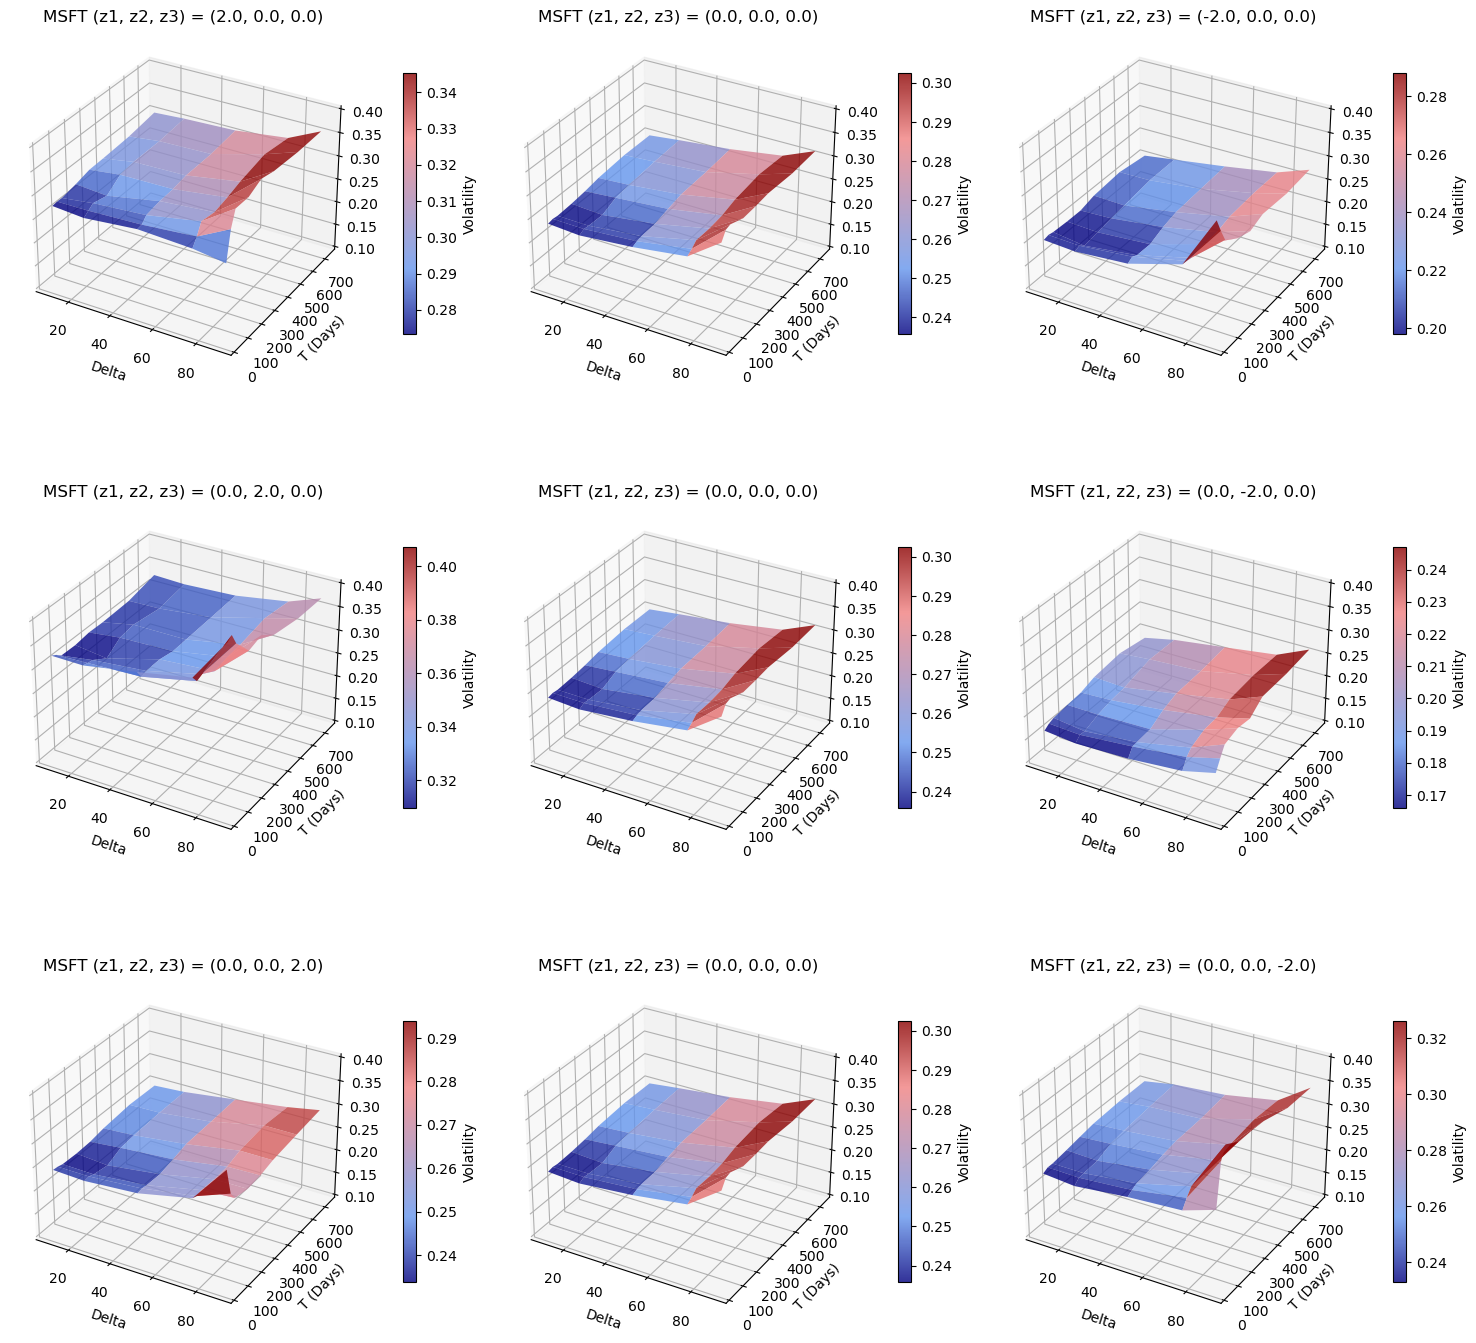

In [14]:
width = 7
wise = 'gridwise'
latent_size = 3
model_version = 7
ticker = 'MSFT'
model = torch.load(f'data/to_use/models/{wise}/{ticker}/{ticker}_model_latentdim{latent_size}_width{width}_v{model_version}')

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})

# Flatten the 2D array of subplots to simplify indexing
axs = axs.flatten()

a = 2.0
latent_z_list = [[a, 0.0, 0.0], [0.0, 0.0, 0.0], [-a, 0.0, 0.0], [0.0, a, 0.0], [0.0, 0.0, 0.0],
                 [0.0, -a, 0.0], [0.0, 0.0, a], [0.0, 0.0, 0.0], [0.0, 0.0, -a]]

# Set a common z-axis range
z_min, z_max = 0.1, 0.4  # Adjust these values based on your data range

for i in range(9):
    z1, z2, z3 = latent_z_list[i]
    latent_z = torch.tensor([[z1, z2, z3]])

    model.eval()

    reconstructed_surf = model.decoder(latent_z)
    title = f'{ticker} (z1, z2, z3) = ({z1}, {z2}, {z3})'
    
    # Call your function with the current subplot
    plot_IVS_simple(reconstructed_surf.squeeze(), ax=axs[i], title=title)
    
    # Set the z-axis limits
    axs[i].set_zlim(z_min, z_max)

# Adjust layout
plt.tight_layout()

# Display the final figure
path = os.getcwd()
parent = os.path.dirname(path)
plt.savefig(f'{parent}/figures/result_figures/IVS9_l{latent_size}_{ticker}.png')
plt.show()

## Part 1.2 | Full error data

In [15]:
import warnings
from dieboldmariano import dm_test
warnings.filterwarnings('ignore')

# Choose the model and ticker you want to analyse. Within this notebook, please keep the variable 'wise' fixed.
width = 7
model_version = 7
wise = 'gridwise'
criterion = nn.MSELoss()


# Initialze list to store losses
loss_list = []
latent_size_list = [1, 2, 3, 4]


# Create dataframe to track the output
error_output = pd.DataFrame(index = latent_size_list, columns = ticker_list)

# Create a dictionary containing all the lists of forecasts
fc_dict = dict()

with torch.no_grad():
    for t in ticker_list:
        # Get the path of the test set
        ts_path = f'data/to_use/{t}_test'
        test_dataset = IVSDataset(ts_path)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  
            
        for l in latent_size_list:
            # Initialize a list of losses to store every samples loss
            loss_list = []
            
            # Initialize a list for storing all the forecasts
            fc_list = []
            
            # Needed to store the z_vals found during training
            columns = []
            
            model = torch.load(f'data/to_use/models/{wise}/{t}/{t}_model_latentdim{l}_width{width}_v{model_version}')
            # Put the model in eval mode
            model.eval()
            with torch.no_grad():
                # This creates a seperate list of column names based on the latent dimension
                for i in range(l):
                    columns.append(f'Z_{i+1}')

                # Create the DataFrame that keeps track of all the z_vals
                z_df = pd.DataFrame(columns=columns)

                # Loop through every image and make a forecast
                for (img, _) in test_dataloader:
                    z = model.encoder(img)
                    reconstructed_surf = model.decoder(z)
                    fc_list.append(reconstructed_surf.squeeze())
                    loss = criterion(reconstructed_surf, img)
                    loss_list.append(loss)

                    # Data manipulation needed to store the z tensor in the z dataframe
                    z = z.detach().numpy()

                    # Convert the NumPy array to a temporary DataFrame
                    temp_df = pd.DataFrame(z, columns = columns)

                    # Append the temporary DataFrame to the main DataFrame
                    z_df = z_df.append(temp_df, ignore_index = True)

                # Saving the z_values used during the forecasting exercise
                z_df.to_csv(f'data/to_use/output/{wise}/{t}/FORECASTING_z_values{l}_v{model_version}')

                final_loss = float(sum(loss_list) / len(loss_list))
                error_output[t][l] = final_loss
                
                # Store the list of all the forecasts in the results dictionary
                fc_dict[f'{t}{l}'] = fc_list

print(f'This is the error output for model version {model_version}') 
pd.set_option('display.float_format', lambda x: '%.5f' % x)
error_output


This is the error output for model version 7


,MSFT,TSLA,XOM,SPX
1,0.00493,0.06561,0.03021,0.01665
2,0.00379,0.04775,0.03093,0.00300
3,0.00343,0.09300,0.01941,0.00157
4,0.00382,0.07120,0.01622,0.00334


## Part 1.2b | Diebold Mariano tests
Based on the above output data I will perform a DM test to compare if the best forecast is statistically different from the second best forecast within each ticker. The choice for the DM tests will therefore be hard coded based on the most recent results used in the thesis.

In [16]:
# Create a pd DataFrame for the truth values
truth_df = pd.DataFrame(index = dates)
for t in ticker_list:
    truth_df[f'{t}_truth'] = truth_tensor_dict[t]

# Create a pd DataFrame for all the forecasts
forecast_df = pd.DataFrame(columns = fc_dict.keys(), index = dates)    
for key in fc_dict.keys():
    forecast_df[key] = fc_dict[key]

In [18]:
model_A = 'SPX3'
model_B = 'SPX2'




# Convert lists of tensors to tensors
forecasts_A = torch.stack(fc_dict[model_A], dim=0).squeeze(dim=-1)
forecasts_B = torch.stack(fc_dict[model_B], dim=0).squeeze(dim=-1)
truth = torch.stack(truth_tensor_dict['MSFT'], dim=0).squeeze(dim=-1)

# 1. Calculate differences in forecast errors
errors_A = (truth - forecasts_A).pow(2).mean(dim=1)
errors_B = (truth - forecasts_B).pow(2).mean(dim=1)
squared_diff = (errors_A - errors_B).pow(2)

# 2. Compute average of squared differences
avg_squared_diff = squared_diff.mean().item()

# 3. Calculate standard error of differences
se_diff = squared_diff.std().item() / len(squared_diff)

# 4. Compute Diebold-Mariano test statistic
dm_statistic = avg_squared_diff / se_diff
print(f'DM statistic for {model_A} vs {model_B} = {dm_statistic}')
# 5. Compare with critical value (e.g., from standard normal distribution)
alpha = 0.01
critical_value = 1.96  # For a two-tailed test at 5% significance

# Check if the test statistic is significant
if abs(dm_statistic) > critical_value:
    print(f"The difference is statistically significant for alpha {alpha}.")
else:
    print(f"There is no significant difference for alpha {alpha}.")

DM statistic for SPX3 vs SPX2 = 95.06524342098352
The difference is statistically significant for alpha 0.01.


## Part 1.3 | Regional error data

In [19]:
# Choose the model and ticker you want to analyse. Within this notebook, please keep the variable 'wise' fixed.
width = 7
model_version = 7
wise = 'gridwise'
criterion = nn.MSELoss()

# This part is needed to create a list of indices to access the correct points regarding to low/high delta
index_list_atm = []
index_list_low_d = []
index_list_high_d = []

for i in range(2, 39, 5):
    index_list_atm.append(i)
    index_list_low_d.append(i-2)
    index_list_low_d.append(i-1)
    index_list_high_d.append(i+1)
    index_list_high_d.append(i+2)

# Define the list of regions to search
# region_list = ['low_tenor', 'mid_tenor', 'high_tenor']
region_dict = {'low_tenor': (0,10), 'mid_tenor' : (10, 30), 'high_tenor' : (30, 40),
               'low_delta':index_list_low_d, 'mid_delta' : index_list_atm, 'high_delta' : index_list_high_d}

region_list = list(region_dict.keys())
# Initialze list to store losses
loss_list = []
latent_size_list = [1, 2, 3, 4]


# Create dataframe to track the output
error_output = pd.DataFrame(index = latent_size_list, columns = region_list)

with torch.no_grad():
    for t in ticker_list:
        # Get the path of the test set
        ts_path = f'data/to_use/{t}_test'
        test_dataset = IVSDataset(ts_path)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  

        for l in latent_size_list:

            model = torch.load(f'data/to_use/models/{wise}/{t}/{t}_model_latentdim{l}_width{width}_v{model_version}')
            # Put the model in eval mode
            model.eval()
            for r in region_list:
                # Initialize a list of losses to store every samples loss
                loss_list = []
                if 'tenor' in r:
                    # Define upper and lower bound for the slice of the sample and reconstructed surface
                    lb = region_dict[r][0]
                    ub = region_dict[r][1]
    
                # Loop through every image and make a forecast
                for (img, _) in test_dataloader:
                    z = model.encoder(img)
                    reconstructed_surf = model.decoder(z)

                    if 'tenor' in r:
                        loss = criterion(reconstructed_surf[:, lb:ub], img[:, lb:ub])
                    if 'delta' in r:
                        loss = criterion(reconstructed_surf[:,region_dict[r]], img[:, region_dict[r]])
                        
                    loss_list.append(loss)
                    
                final_loss = float(sum(loss_list) / len(loss_list))
                error_output[r][l] = final_loss
        print(f'Printing error output for ticker: {t}')     
        pd.options.display.float_format = "{:,.4f}".format
        display(error_output)

Printing error output for ticker: MSFT


,low_tenor,mid_tenor,high_tenor,low_delta,mid_delta,high_delta
1,0.0090,0.0043,0.0021,0.0037,0.0047,0.0063
2,0.0081,0.0031,0.0008,0.0014,0.0022,0.0070
3,0.0077,0.0025,0.0009,0.0022,0.0029,0.0050
4,0.0072,0.0033,0.0015,0.0021,0.0029,0.0060


Printing error output for ticker: TSLA


,low_tenor,mid_tenor,high_tenor,low_delta,mid_delta,high_delta
1,0.0729,0.0642,0.0611,0.0812,0.0620,0.0518
2,0.0730,0.0432,0.0316,0.0437,0.0351,0.0582
3,0.1246,0.0880,0.0713,0.1038,0.0824,0.0875
4,0.0782,0.0714,0.0638,0.0861,0.0648,0.0595


Printing error output for ticker: XOM


,low_tenor,mid_tenor,high_tenor,low_delta,mid_delta,high_delta
1,0.0362,0.0278,0.0290,0.0301,0.0313,0.0297
2,0.0367,0.0290,0.0290,0.0307,0.0317,0.0308
3,0.0239,0.0178,0.0182,0.0190,0.0199,0.0195
4,0.0217,0.0146,0.0141,0.0144,0.0158,0.0183


Printing error output for ticker: SPX


,low_tenor,mid_tenor,high_tenor,low_delta,mid_delta,high_delta
1,0.0176,0.0155,0.0180,0.0233,0.0182,0.0092
2,0.0047,0.0027,0.0018,0.0009,0.0023,0.0054
3,0.0024,0.0013,0.0014,0.0006,0.0012,0.0027
4,0.0051,0.0031,0.0020,0.0008,0.0022,0.0064


## Part 1.4 | The latent variable during training

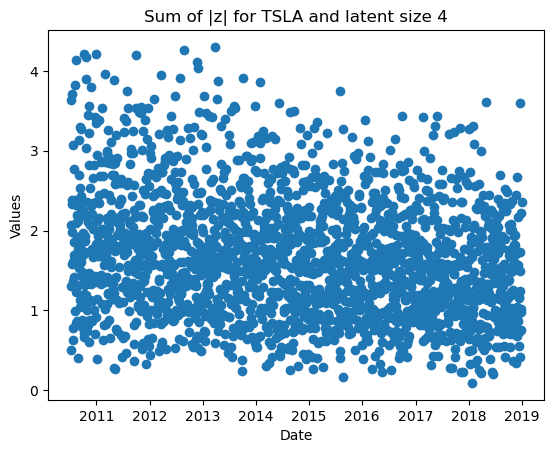

In [20]:
ticker = 'TSLA'
l = 4
model_version = 7


path = f'data/to_use/output/{wise}/{ticker}/TRAINING_z_values{l}_v{model_version}'
z_df = pd.read_csv(path)
z_df = z_df.drop(['Unnamed: 0'], axis='columns')

# Create a new column which is the sum of all the z_values
z_df['abs_sum_Z'] = z_df.abs().sum(axis=1)


tr_path = f'data/to_use/{ticker}_train'
tr_df = pd.read_csv(tr_path)

# Obtain only the last third of the z-dataframe since we used 3 epochs and are only interested in the last one
# First count the total unique dates
count_dates = len(tr_df)/40

# Slice after the first two epochs have finished to obtian the z-vals for the third epoch
z_df = z_df[int(2*count_dates):]
z_df['date'] = tr_df['date'].unique()

z_df['date'] = pd.to_datetime(z_df['date'])

# Plot the scatter plot
plt.scatter(z_df['date'], z_df['abs_sum_Z'], marker='o')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(f'Sum of |z| for {ticker} and latent size {l}')

# Show the plot
plt.show()

    

## Part 1.5 | The sum of latent variables during out of sample testing

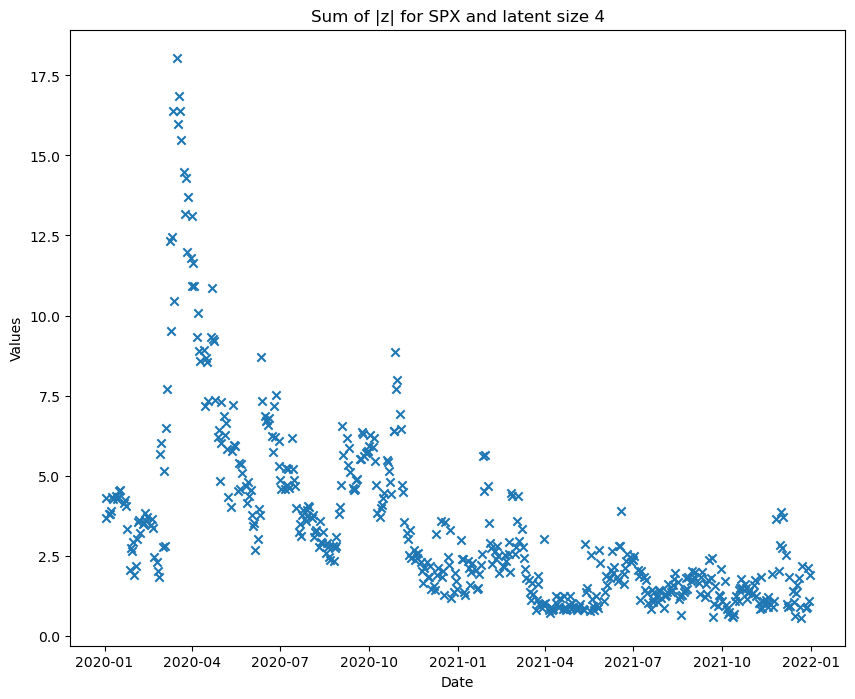

In [238]:
# Choose the model and ticker you want to analyse. Within this notebook, please keep the variable 'wise' fixed.
width = 7
model_version = 7
wise = 'gridwise'
criterion = nn.MSELoss()

t = 'SPX'
l = 4
# Initialze list to store losses
loss_list = []



    
# Saving the z_values used during the forecasting exercise
z_df = pd.read_csv(f'data/to_use/output/{wise}/{t}/FORECASTING_z_values{l}_v{model_version}')

z_df = z_df.drop(['Unnamed: 0'], axis='columns')

# Create a new column which is the sum of all the z_values
z_df['abs_sum_Z'] = z_df.abs().sum(axis=1)


ts_path = f'data/to_use/{t}_test'
ts_df = pd.read_csv(ts_path)

if t != 'ALL':
    z_df['date'] = ts_df['date'].unique()
    

z_df['date'] = pd.to_datetime(z_df['date'])


plt.figure(figsize=(10, 8))  # Set the figure size
# Plot the scatter plot
plt.scatter(z_df['date'], z_df['abs_sum_Z'], marker='x')
# plt.scatter(vix['date'], vix['value'], marker='o', color='purple', label='VIX')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(f'Sum of |z| for {t} and latent size {l}')

# Display the final figure
path = os.getcwd()
parent = os.path.dirname(path)
# plt.savefig(f'{parent}/figures/result_figures/SUMofz_tsplot_l{l}_{t}.png')
plt.show()


## Part 1.6 | The latent variables seperately during out of sample testing

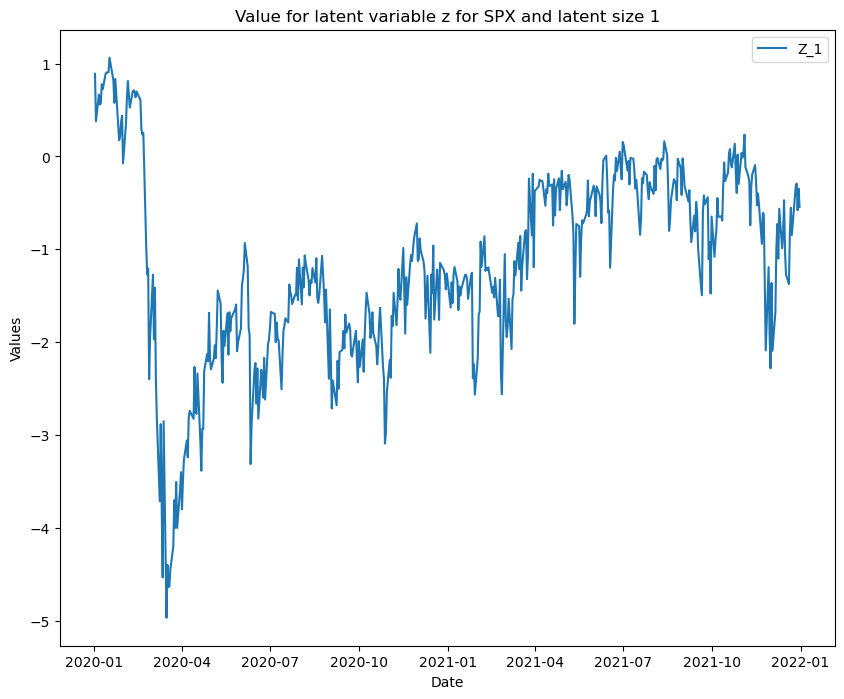

In [21]:
# Choose the model and ticker you want to analyse. Within this notebook, please keep the variable 'wise' fixed.
width = 7
model_version = 7
wise = 'gridwise'
criterion = nn.MSELoss()

t = 'SPX'
l = 1
# Initialze list to store losses
loss_list = []



    
# Saving the z_values used during the forecasting exercise
z_df = pd.read_csv(f'data/to_use/output/{wise}/{t}/FORECASTING_z_values{l}_v{model_version}')

z_df = z_df.drop(['Unnamed: 0'], axis='columns')


ts_path = f'data/to_use/{t}_test'
ts_df = pd.read_csv(ts_path)

if t != 'ALL':
    z_df['date'] = ts_df['date'].unique()
    

z_df['date'] = pd.to_datetime(z_df['date'])


z_cols = z_df.columns[:-1]
plt.figure(figsize=(10, 8))  # Set the figure size
# Plot the scatter plot for each column
for column in z_cols:
    
    plt.plot(z_df['date'], z_df[column],  label=column)

#Set labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(f'Value for latent variable z for {t} and latent size {l}')

# Add a legend
plt.legend()

# Display the final figure
path = os.getcwd()
parent = os.path.dirname(path)
# plt.savefig(f'{parent}/figures/result_figures/z_tsplot_l{l}_{t}.png')
plt.show()



## Part 1.7 | The VIX

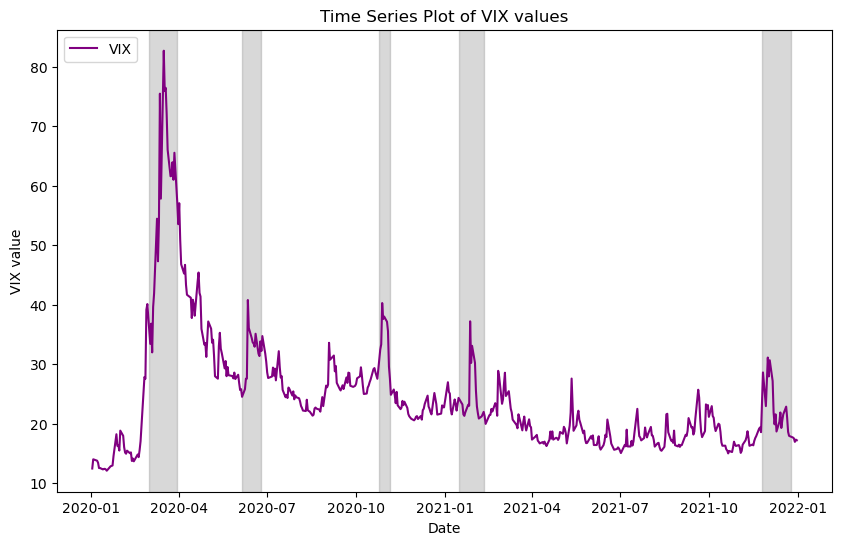

In [22]:
# Load VIX data
vix = pd.read_csv('data/to_use/VIX.csv')
ts_start = pd.to_datetime('2020-01-02')
ts_end = pd.to_datetime('2021-12-31')

# vix = vix.rename(columns={' value': 'value'})
vix['date'] = pd.to_datetime(vix['date'])
vix = vix[(vix['date'] >= ts_start) & (vix['date'] <= ts_end)]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot VIX on the primary y-axis
ax.plot(vix['date'], vix['value'], color='purple', label='VIX')

# Highlight spikes with transparent grey boxes
spike_date_ranges = [('2020-03-01', '2020-03-30'), 
                     ('2020-06-05', '2020-06-25'),
                     ('2020-10-25', '2020-11-05'),
                     ('2021-01-15', '2021-02-10'),
                     ('2021-11-25', '2021-12-25')]  
for start_date, end_date in spike_date_ranges:
    ax.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.3)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('VIX value')
ax.set_title('Time Series Plot of VIX values')
ax.legend()

# Display the final figure
path = os.getcwd()
parent = os.path.dirname(path)
plt.savefig(f'{parent}/figures/result_figures/VIX.png')
plt.show()

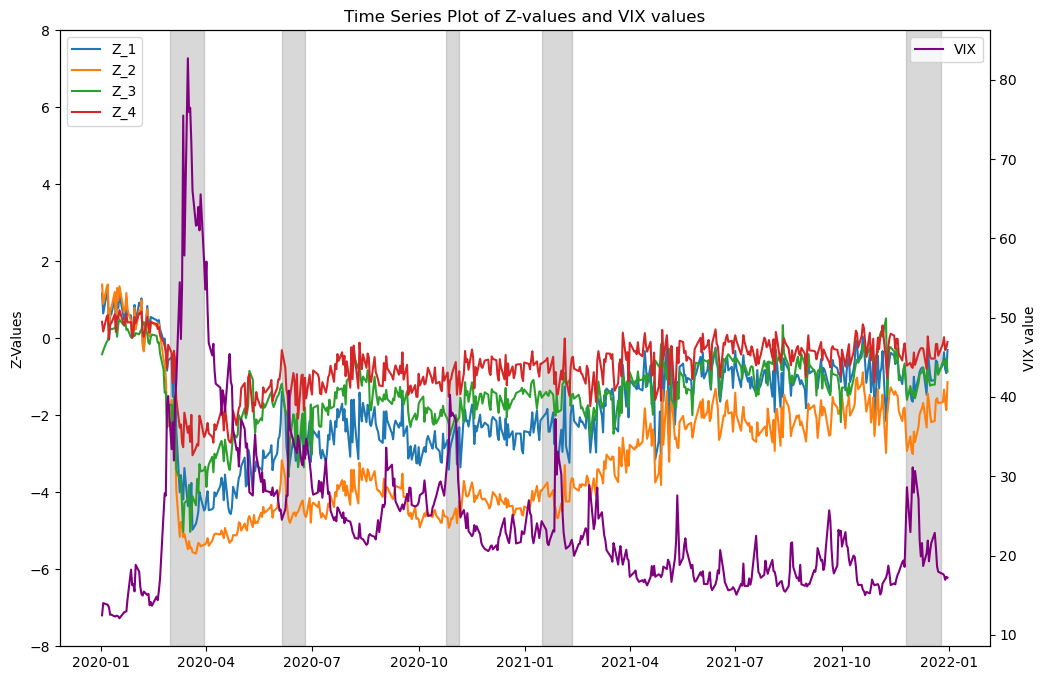

In [23]:
# Load VIX data
vix = pd.read_csv('data/to_use/VIX.csv')
ts_start = pd.to_datetime('2020-01-02')
ts_end = pd.to_datetime('2021-12-31')
vix['date'] = pd.to_datetime(vix['date'])
vix = vix[(vix['date'] >= ts_start) & (vix['date'] <= ts_end)]

# Load z_df data
width = 7
model_version = 7
wise = 'gridwise'
t = 'XOM'
l = 4
z_df = pd.read_csv(f'data/to_use/output/{wise}/{t}/FORECASTING_z_values{l}_v{model_version}')
z_df = z_df.drop(['Unnamed: 0'], axis='columns')
ts_path = f'data/to_use/{t}_test'
ts_df = pd.read_csv(ts_path)
if t != 'ALL':
    z_df['date'] = ts_df['date'].unique()
z_df['date'] = pd.to_datetime(z_df['date'])
z_cols = z_df.columns[:-1]

# Create a figure and axis with twinx
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

# Plot z_df on the secondary y-axis (ax2)
for column in z_cols:
    ax1.plot(z_df['date'], z_df[column], label=column)

ax1.set_ylabel('Z-Values')
ax1.tick_params(axis='y')

ax1.set_ylim([-8,8])

# Add a legend for the secondary axis
ax1.legend(loc='upper left')

# Plot VIX on the primary y-axis (ax1)
ax2.plot(vix['date'], vix['value'], color='purple', label='VIX')
ax2.set_xlabel('Date')
ax2.set_ylabel('VIX value')
ax2.tick_params(axis='y')
ax2.set_title('Time Series Plot of Z-values and VIX values')
ax2.legend(loc='upper right')

# Highlight spikes with transparent grey boxes
spike_date_ranges = [('2020-03-01', '2020-03-30'), 
                     ('2020-06-05', '2020-06-25'),
                     ('2020-10-25', '2020-11-05'),
                     ('2021-01-15', '2021-02-10'),
                     ('2021-11-25', '2021-12-25')]  
for start_date, end_date in spike_date_ranges:
    ax1.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.3)
# Display the final figure
path = os.getcwd()
parent = os.path.dirname(path)
plt.savefig(f'{parent}/figures/result_figures/combined_vix_z_{t}_{l}.png')
plt.show()

# Part 2.1 | Performance of trained model on partial data with calibration



In [24]:
ticker = 'SPX'
model_version = 7
width = 7 #Always fixed
error = 'MSE'
# Create the final dataframe
error_output = pd.DataFrame(index = latent_size_list, columns = subset_size_list)

for s in subset_size_list:
    for l in latent_size_list:
        path = f'data/to_use/output/{wise}/{ticker}/calibration_{ticker}_ss{s}_ld{l}_v{model_version}'
        output = pd.read_csv(path)

        # Apply the function to the entire column
        numpy_cols = ['z', 'fc_vol', 'known_vol_ss']
        for col in numpy_cols:
            output[col] = output[col].apply(string_to_array)


        model = torch.load(f'data/to_use/models/{wise}/{ticker}/{ticker}_model_latentdim{l}_width{width}_v{model_version}')
        print(f'Loaded model and data for: {ticker}; subset size: {s}; latent size: {l}; width: {width} and version {model_version}')
        print(f'calculating the {error}-loss for {ticker}')
        
        # Create a list that contains the full column 
        contracts_column = []
        for row in output['indices']:
            # Create a seperate list that gets assigned to one cel within the contracts_column
            contract_list = []
            # Extract numeric values using regular expression
            int_vals = [int(match) for match in re.findall(r'\b\d+\b', row)]
            for i in int_vals:
                contract_list.append(grid_dict[i])
            contracts_column.append(contract_list)
        output['contracts_used'] = contracts_column
        
        
        ts_path = f'data/to_use/{ticker}_test'
        test_dataset = IVSDataset(ts_path)
        test_dataloader = DataLoader(test_dataset, batch_size=1,
                                     shuffle=False)  # TODO --> the batchsize of the testdataset is fixed to one, possibly change

        # Use dataloader
        test_dataiter = iter(test_dataloader)

        # note that for this use-case the 'images' are the same as the 'labels'
        ts_images, ts_labels = next(test_dataiter)
        
        # Add the ground truth to the output table
        img_list = []
        for (img, _) in test_dataloader:
            img_list.append(img.squeeze().numpy())


        output['known_vol_full'] = img_list        
        
        
        # Set model to eval mode
        model.eval()

        # Define criterion
        if error == 'MAE':
            criterion = nn.L1Loss()
        elif error == 'MSE':
            criterion = nn.MSELoss()

        # Cast to double
        model.double() 

        # Create output list
        fc_vol_full_list = [] 
        loss_of_full_list = []
        counter = 0
        for (img, _) in test_dataloader:
            sample = img[0]
#             print('sample is:', sample)
            z = torch.tensor(output['z'][counter])

#             print(z)
#             print(z.shape)
            z = z.reshape(1,int(l))
            reconstructed_surf = model.decoder(z)
#             print('reconstructed:', reconstructed_surf)
#             print(f'z is: {z}')
#             print(f' sample is: {sample}')
#             print(counter)

            loss = criterion(reconstructed_surf, sample.squeeze())
#             print('loss:', loss)

            fc_vol_full_list.append(reconstructed_surf.squeeze().detach().numpy())
            loss_of_full_list.append(loss.squeeze().detach().numpy())
            counter += 1
        output['fc_vol_full'] = fc_vol_full_list    
        output['loss_of_full'] = loss_of_full_list
        
        
        error_output[s][l] = output['loss_of_full'].mean()
        
error_output.to_csv(f'data/to_use/output/{wise}/{ticker}/error_output_{error}_{ticker}_v{model_version}')

Loaded model and data for: SPX; subset size: 5; latent size: 1; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subset size: 5; latent size: 2; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subset size: 5; latent size: 3; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subset size: 5; latent size: 4; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subset size: 10; latent size: 1; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subset size: 10; latent size: 2; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subset size: 10; latent size: 3; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subset size: 10; latent size: 4; width: 7 and version 7
calculating the MSE-loss for SPX
Loaded model and data for: SPX; subs

In [25]:
ticker = 'SPX'
model_version = '7'
error = 'MSE'
error_df = pd.read_csv(f'data/to_use/output/{wise}/{ticker}/error_output_{error}_{ticker}_v{model_version}')
pd.options.display.float_format = "{:,.5f}".format
error_df

,Unnamed: 0,5,10,15,20,25,30,35,40
0,1,0.00209,0.00190,0.00183,0.00182,0.00179,0.00178,0.00177,0.00177
1,2,0.00171,0.00143,0.00130,0.00125,0.00121,0.00115,0.00111,0.00110
2,3,0.00217,0.00161,0.00139,0.00124,0.00119,0.00115,0.00110,0.00107
3,4,0.00207,0.00144,0.00136,0.00141,0.00119,0.00116,0.00126,0.00133


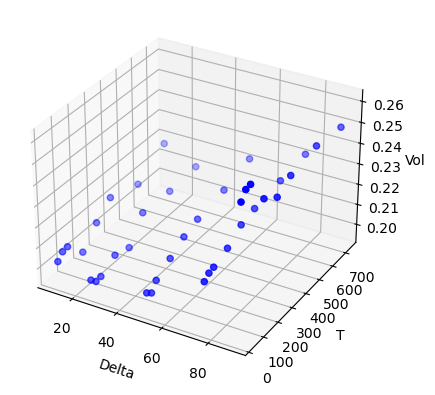

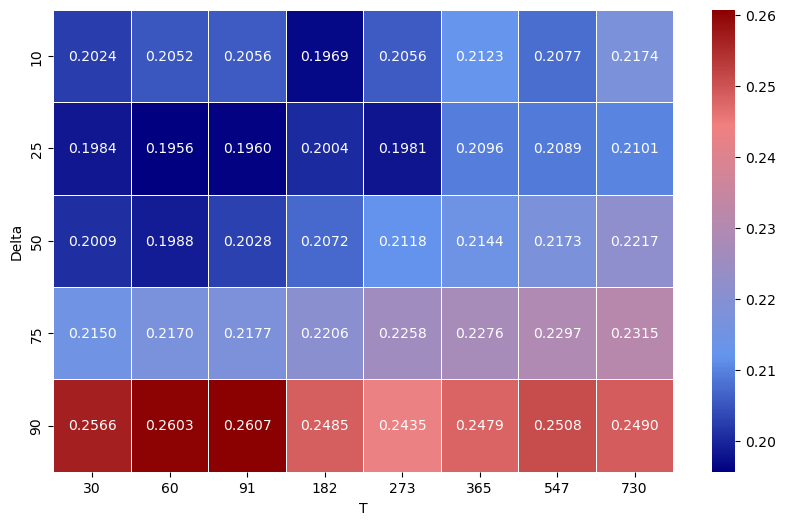

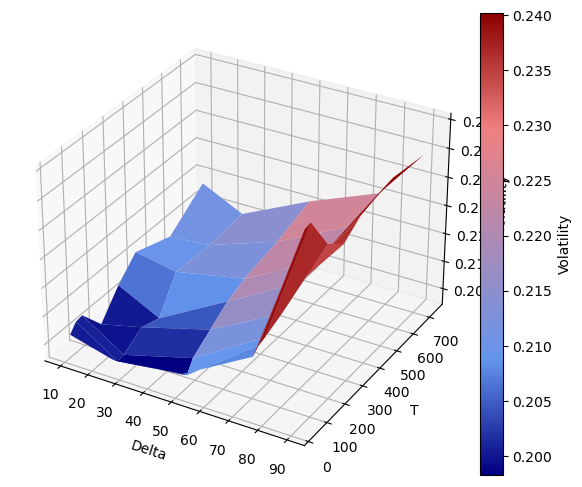

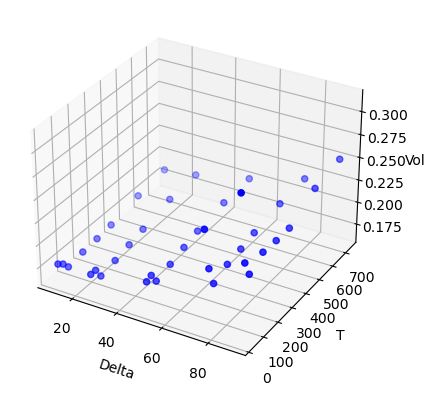

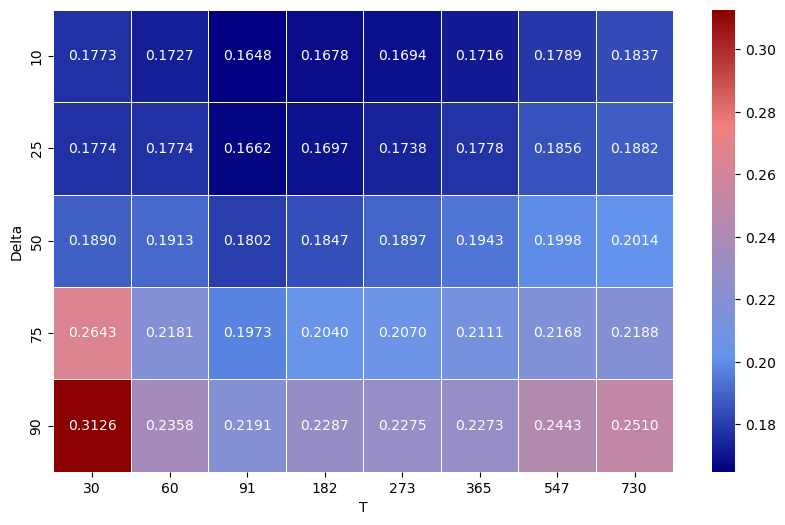

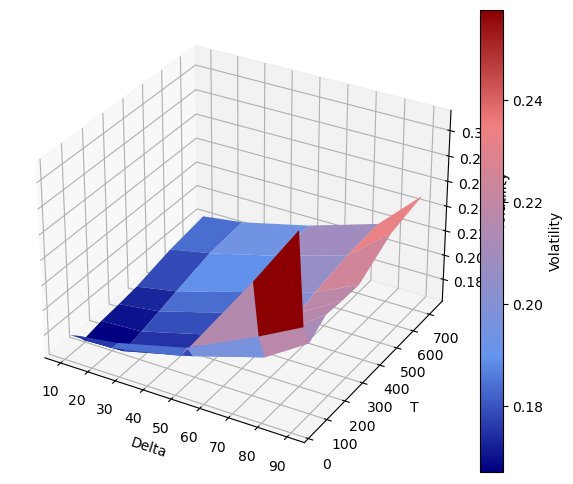

In [26]:
# Choose the model and ticker you want to analyse. Within this notebook, please keep the variable 'wise' fixed.
latent_size = 3
width = 7
model_version = 7

# Pick ticker. See cell for data_preseetings for the current ticker_list
ticker = 'XOM'
wise = 'gridwise'

# Change this number to check a different sample, 505 samples availble, first sample = 0.
# Sample number 50 corresponds to 16-03-2020, the day the COVID-19 crisis first hit the markets
sample_number = 0


# Get the path of the test set
ts_path = f'data/to_use/{ticker}_test'
test_dataset = IVSDataset(ts_path)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  

# Use dataloader
test_dataiter = iter(test_dataloader)

# Note that for this use-case the 'images' are the same as the 'labels'
ts_images, ts_labels = next(test_dataiter)

# Create a list of all the testsamples
test_sample_list = []
for (img, _) in test_dataloader:
    test_sample_list.append(img)
    

model = torch.load(f'data/to_use/models/{wise}/{ticker}/{ticker}_model_latentdim{latent_size}_width{width}_v{model_version}')
model.eval()

with torch.no_grad():
    z = model.encoder(test_sample_list[sample_number])
#     z = torch.tensor([0.0, 0.0, -5.0])
    z = z.reshape(1,latent_size)
    reconstructed_surf = model.decoder(z)
    plot_IVS(reconstructed_surf.squeeze())
    plot_IVS(test_sample_list[sample_number].detach().squeeze())

# Part 2.2 | Calibrated Z_values 

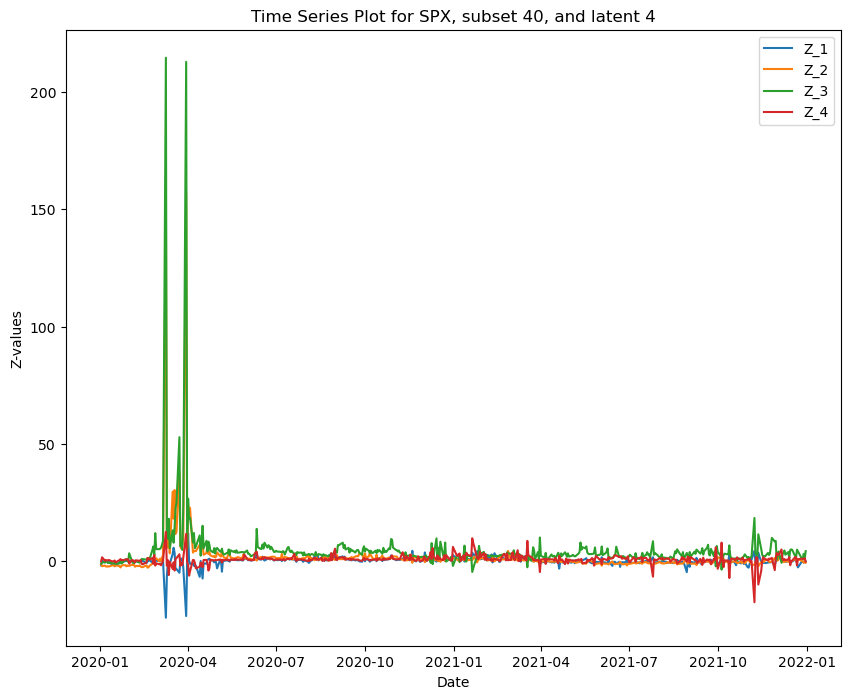

In [28]:
t = 'SPX'
s = 40
latent = 4
model_version = 7
path = f'data/to_use/output/{wise}/{t}/calibration_{t}_ss{s}_ld{latent}_v{model_version}'
output = pd.read_csv(path)


# Apply the function to the entire column
numpy_cols = ['z', 'fc_vol', 'known_vol_ss']
for col in numpy_cols:
    output[col] = output[col].apply(string_to_array)


# Create a list that contains the full column 
contracts_column = []
for row in output['indices']:
    # Create a seperate list that gets assigned to one cel within the contracts_column
    contract_list = []
    # Extract numeric values using regular expression
    int_vals = [int(match) for match in re.findall(r'\b\d+\b', row)]
    for i in int_vals:
        contract_list.append(grid_dict[i])
    contracts_column.append(contract_list)
output['contracts_used'] = contracts_column


ts_path = f'data/to_use/{ticker}_test'
test_dataset = IVSDataset(ts_path)
test_dataloader = DataLoader(test_dataset, batch_size=1,
                             shuffle=False)  # TODO --> the batchsize of the testdataset is fixed to one, possibly change

# Use dataloader
test_dataiter = iter(test_dataloader)

# note that for this use-case the 'images' are the same as the 'labels'
ts_images, ts_labels = next(test_dataiter)

# Add the ground truth to the output table
img_list = []
for (img, _) in test_dataloader:
    img_list.append(img.squeeze().numpy())
output['known_vol_full'] = img_list 

z_df = pd.DataFrame()

# Saving the z_values used during the forecasting exercise
z_df['z'] = output['z']



ts_path = f'data/to_use/{t}_test'
ts_df = pd.read_csv(ts_path)

if t != 'ALL':
    z_df['date'] = ts_df['date'].unique()

z_df['date'] = pd.to_datetime(z_df['date'])


# Make empty collist
cols = []
for l in range(latent):
    cols.append(f'Z_{l+1}')

# Extract each seperate z value from the array and store it in corresponding col
z_df[cols] = pd.DataFrame(z_df['z'].tolist(), index=z_df.index)

# Scatter plot for the first value
plt.figure(figsize=(10, 8))  
for i in range(1, l+2):
    plt.plot(z_df['date'],z_df[f'Z_{i}'], label=f'Z_{i}')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Z-values')
plt.title(f'Time Series Plot for {t}, subset {s}, and latent {latent}')
plt.legend()

# Show the plot
plt.show()

